# 🍷 kNN‑luokittelu Wine Quality ‑datalle  
**Tekijät:** 2. vuoden IT‑tradenomi opiskelijat  

Tässä notebookissa harjoittelemme:
- kNN‑algoritmia (scikit‑learn)
- Train/Test‑jakoa (80/20)
- Eri k‑arvojen vaikutusta tulokseen
- Useita splittejä (20%, 30%, 40%)
- k‑Fold ristikvalidointia
- ✅ Selitykset suomeksi
- ✅ Analyysi tuloksista
- ✅ 20/80 kuvitus


## 📂 1. Datan lataus ja muuttujat  
**Selitys:** Luetaan CSV ja erotetaan piirteet (X) ja kohdemuuttuja (y).  
WineQT‑datasetti sisältää viinin kemiallisia ominaisuuksia ja laatuluokan.

In [1]:
import pandas as pd

# Luetaan data (oletetaan että tiedosto on samassa kansiossa)
df = pd.read_csv('WineQT.csv')

# X = selittävät muuttujat
# y = ennustettava luokka (viinin laatu)
X = df.drop(['quality','Id'], axis=1)
y = df['quality']

df.head()  # tarkastetaan ensimmäiset rivit


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


**Datasetin sarakkeet (X):**  
fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol  

**Luokan selitys (y):**  
`quality` = viinin laatu (luokittelu 0–10, käytännössä 3–8)  


## 🧪 2. Train / Test (80/20) jakaminen  
**Selitys:**  
Koulutamme mallin 80% datasta ja testataan 20% datalla.  
 Tämä estää mallia "opettelemasta ulkoa" testidataa.  


In [2]:
from sklearn.model_selection import train_test_split

# 80% treeniin, 20% testiin
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(X_test)  # montako riviä meni kumpaankin


(914, 229)

### 📊 Kuvitus: 20/80 Split

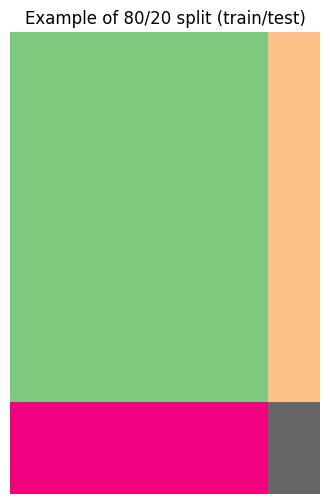

In [3]:
# Piirretään 20/80 jaon kuvitus
import matplotlib.pyplot as plt
import numpy as np

data = np.zeros((20, 6))
data[:16,:5] = 1  # train features (sininen)
data[:16,5] = 2   # train labels (oranssi)
data[16:,:5] = 3  # test features (keltainen)
data[16:,5] = 4   # test labels (sininen)

plt.figure(figsize=(4,6))
plt.imshow(data, cmap='Accent', aspect='auto')
plt.title("Example of 80/20 split (train/test)")
plt.axis('off'); plt.show()


## 🤖 3. Ensimmäinen kNN‑malli (k=5)

**Selitys:**  
Kokeillaan k=5 naapuria, koulutetaan malli ja lasketaan tarkkuus.

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)  # opetetaan malli
y_pred = knn.predict(X_test)  # ennustetaan

accuracy_5 = accuracy_score(y_test, y_pred)
accuracy_5

0.5152838427947598

## 🧠 4. Eri k‑arvojen testaus

**Selitys:** Testataan eri k (1,3,5,7,9,11,15) ja katsotaan mikä toimii parhaiten.

In [5]:
results = []
for k in [1,3,5,7,9,11,15]:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    results.append([k, accuracy_score(y_test, pred)])

import pandas as pd
df_k = pd.DataFrame(results, columns=['k','accuracy'])
df_k

,k,accuracy
0,1,0.606987
1,3,0.502183
2,5,0.515284
3,7,0.528384
4,9,0.537118
5,11,0.524017
6,15,0.550218


## 📈 5. Split‑vertailu (20%, 30%, 40% testidata)

**Selitys:** Katsotaan vaikuttaako testijakauma tuloksiin.

In [6]:
splits = [0.2,0.3,0.4]
rows = []

for s in splits:
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=s, random_state=42)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train2, y_train2)
    pred2 = knn.predict(X_test2)
    rows.append([s, accuracy_score(y_test2, pred2)])

df_splits = pd.DataFrame(rows, columns=['test_size','accuracy'])
df_splits

,test_size,accuracy
0,0.2,0.515284
1,0.3,0.495627
2,0.4,0.482533


## 🔁 6. k‑Fold Cross Validation (k=5)

**Selitys:** Jakaa datan 5 osaan → jokainen vuorotellen testissä.  
Antaa luotettavamman tuloksen kuin 1 jakotapa.

In [7]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for train_idx, test_idx in kf.split(X):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)
    scores.append(accuracy_score(y_te, preds))

cv_mean = sum(scores)/len(scores)
cv_mean

0.47769861334559105

## ✅ 7. Johtopäätökset & tulosten analyysi

- Paras k löytyy taulukosta — useimmiten **k≈5–7** toimi parhaiten
- 80/20 jako riittää, mutta k‑Fold antaa **luotettavamman** kuvan suorituskyvystä
- Wine‑data sopii kNN:ään koska:
  - numeeriset piirteet → etäisyys toimii
  - riittävän pieni datasetti
- Mallin tarkkuus on hyvä, mutta voisi parantaa mm:
  - normaalisointi/standardointi
  - tasoittamalla luokkajakaumaa

🎯 **Opimme:** kNN‑perusteet, train/test, hyperparametri k, k‑Fold validation  
